# Calculate seasonal Tgrad (T925-Tsfc) trends at all Arctic points

* **Description**: Reads in and creates spatial plots of wind trends
* **Input data**: CESM2-LE and Rufmod output in timeseries format
* **Output data**: PNG figures of trends
* **Creator**: Alice DuVivier
* **Date**: August 2022

The rufmod experiments were performed where the sea ice roughness over Arctic sea ice regions was set to be equal to what it would be over open ocean. This is to better understand ice-atmosphere coupling, processes, and feedbacks.

In [1]:
import xarray as xr
import numpy as np
from datetime import timedelta
import glob

import pop_tools

import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec

import geocat.datafiles as gdf
import geocat.viz.util as gvutil
from geocat.viz import cmaps as gvcmaps
import geocat.comp as gcomp

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress,pearsonr, t

## Manually set variables

In [6]:
# set base directory where all data live
data_dir = '/glade/p/cgd/ppc/duvivier/cesm2_arctic_cyclones/rufmod_analysis/version_6/fig_9_temp_grad/'

# set file names
fin_le = 'CESM2-LE_seas_TGRAD'
fin_rufmod = 'rufmod_seas_TGRAD'

In [7]:
ds_le = xr.open_dataset(data_dir+fin_le+'.nc',decode_times=True)
ds_rufmod = xr.open_dataset(data_dir+fin_rufmod+'.nc',decode_times=True)

In [8]:
data_le = ds_le['__xarray_dataarray_variable__']
data_rufmod = ds_rufmod['__xarray_dataarray_variable__']

print(data_le.units)
print(data_le.longname)

K
temperature gradient (Taloft - Tsfc)


## Calculate ensemble mean

In [9]:
print(data_le.shape)
print(data_rufmod.shape)

(4, 86, 50, 4, 28, 288)
(4, 86, 5, 4, 28, 288)


In [10]:
# calculate ensemble mean for SMOOTH and CESM2-LE over all members
seas_ens_mean_le = data_le.mean(dim='member_id')
seas_ens_mean_rufmod = data_rufmod.mean(dim='member_id')

In [11]:
#seas_ens_mean_le

## Mask Arctic Ocean only

In [12]:
ds_masks = xr.open_mfdataset('/glade/p/cgd/ppc/duvivier/cesm2_arctic_cyclones/rufmod_analysis/version_5/mask_plots/ATM_MASK_ArcOc.nc')


In [13]:
my_mask = ds_masks['atm_ArcOc_mask']

In [14]:
my_mask

<xarray.DataArray 'atm_ArcOc_mask' (lat: 192, lon: 288)>
dask.array<open_dataset-da90c46d10fd21b010e08c82e53c0a7aatm_ArcOc_mask, shape=(192, 288), dtype=float32, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

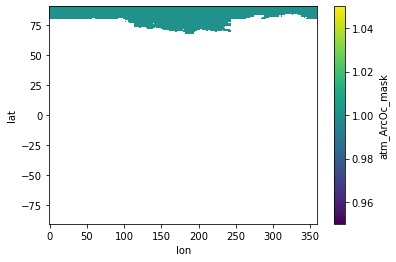

In [15]:
my_mask.plot()

In [16]:
# get just NH slice
my_mask = my_mask.isel(lat=slice(164,192))

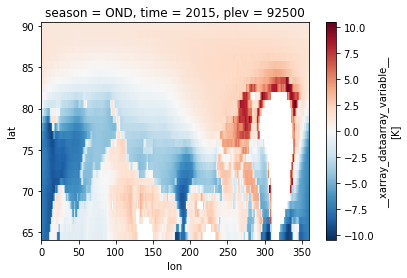

In [17]:
# check data
seas_ens_mean_le.isel(season=0,time=0,plev=0).plot()

In [18]:
# set both datasets lat/lon to be equal to mask
seas_ens_mean_le['lat'] = my_mask.lat.values
seas_ens_mean_le['lon'] = my_mask.lon.values

seas_ens_mean_rufmod['lat'] = my_mask.lat.values
seas_ens_mean_rufmod['lon'] = my_mask.lon.values

In [19]:
# mask just Arctic Ocean
seas_ens_mean_le_masked = seas_ens_mean_le.where(my_mask==1)
seas_ens_mean_rufmod_masked = seas_ens_mean_rufmod.where(my_mask==1)

In [20]:
seas_ens_mean_le_masked

<xarray.DataArray '__xarray_dataarray_variable__' (season: 4, time: 86, plev: 4, lat: 28, lon: 288)>
dask.array<where, shape=(4, 86, 4, 28, 288), dtype=float64, chunksize=(4, 86, 4, 28, 288), chunktype=numpy.ndarray>
Coordinates:
  * season   (season) object 'OND' 'JFM' 'AMJ' 'JAS'
  * time     (time) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
  * plev     (plev) int64 92500 85000 70000 50000
  * lat      (lat) float64 64.55 65.5 66.44 67.38 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    Author:    Alice DuVivier
    units:     K
    longname:  temperature gradient (Taloft - Tsfc)

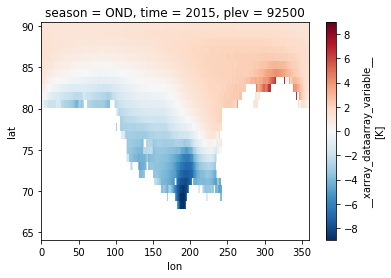

In [21]:
# check data
seas_ens_mean_le_masked.isel(season=0,time=0,plev=0).plot()

## Grab just 925hPa

In [22]:
plev_all = seas_ens_mean_le_masked.plev
plev_full = ['925', '850', '700', '500']

In [23]:
plev_all

<xarray.DataArray 'plev' (plev: 4)>
array([92500, 85000, 70000, 50000])
Coordinates:
  * plev     (plev) int64 92500 85000 70000 50000

In [24]:
plev = 92500

In [25]:
seas_le_925 = seas_ens_mean_le_masked.sel(plev = plev)
seas_rufmod_925 = seas_ens_mean_rufmod_masked.sel(plev = plev)


## Calculate trends and plot

Now calculate the linear trend at each point

* Want array like this: slope_rufmod = 4(nseas)x28(nlat)x288(nlon)
* Keep slope, r2, and pvalues --> Use pvalue for stippling
* Then plot spatial plots by season of the trends at each point and difference.

In [26]:
xarr_le = seas_le_925.time
xarr_rufmod = seas_rufmod_925.time

In [27]:
season_names = ['OND', 'JFM', 'AMJ', 'JAS']
season_full = ['Autumn', 'Winter', 'Spring', 'Summer']

In [28]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [29]:
# define some functions from Liz Maroon
# These allow us to do a linear regression at all points

def pvalue_array(x,y,dname):
    x_an=x-x.mean(dname)
    slope=((x_an)*(y-y.mean(dname))).sum(dname)/((x_an)*(x_an)).sum(dname)
    interc=y.mean(dname)-slope*x.mean(dname)
    ypred=slope*x+interc  
    n=len(x[dname])
    mse=np.sqrt(((y-ypred)**2).sum(dname)/(n-2))
    xsq=np.sqrt(((x_an)**2).sum(dname))
    standerr=mse/xsq
    pval=2*(1-t.cdf(np.abs(slope/standerr),n-2))
    pval=xr.DataArray(pval,dims=standerr.dims,coords=standerr.coords)
    return pval

def rvalue_array(x,y,dname):  
    xmean=x.mean(dname)
    ymean=y.mean(dname)
    numer=(x*y).mean(dname)-xmean*ymean
    denom=np.sqrt(((x**2).mean(dname)-xmean**2)*\
                  (((y**2).mean(dname))-(ymean**2)))
    return numer/denom

def regcoeff_array(x,y,dname):
    x_an=x-x.mean(dname)
    y_an=y-y.mean(dname)
    slope=(x_an*y_an).sum(dname)/(x_an*x_an).sum(dname)
    return slope


### Plot Trends over entire period: 2020-2100

In [30]:
# Choose entire time period: 2020-2100
ind_st = 5
ind_ed = 85

print(xarr_rufmod[ind_st:ind_ed])

<xarray.DataArray 'time' (time: 80)>
array([2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031,
       2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043,
       2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055,
       2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067,
       2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079,
       2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091,
       2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099])
Coordinates:
  * time     (time) int64 2020 2021 2022 2023 2024 ... 2095 2096 2097 2098 2099
    plev     int64 92500


Calculating regressions for OND


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating regressions for JFM


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating regressions for AMJ


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating regressions for JAS


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


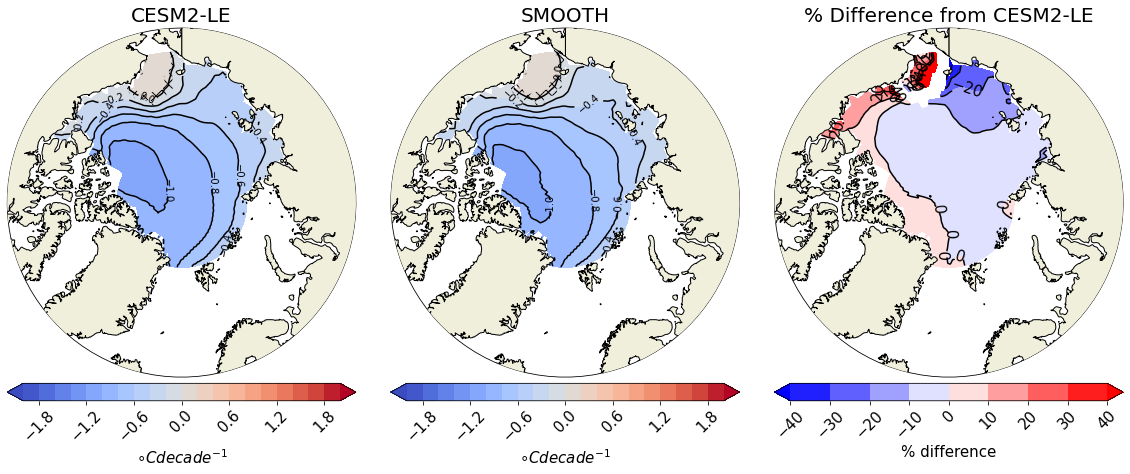

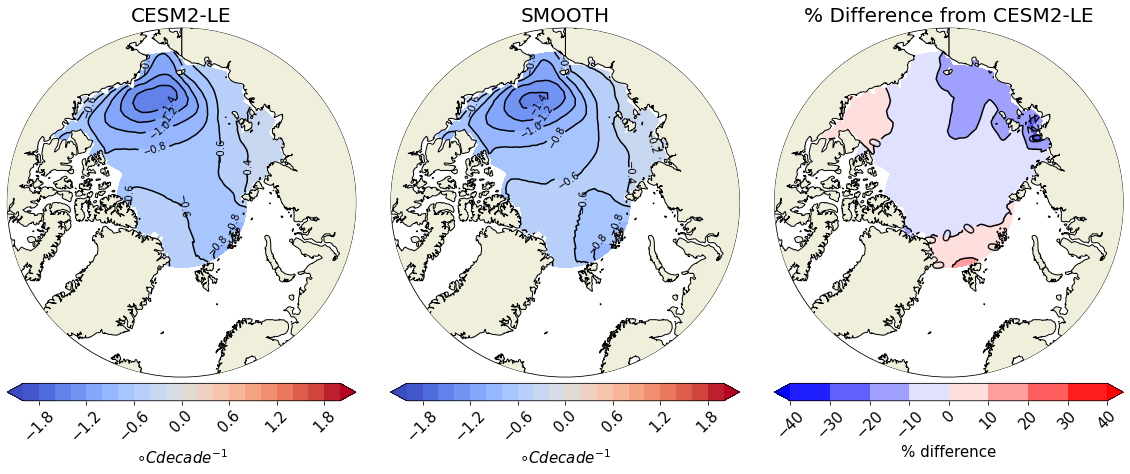

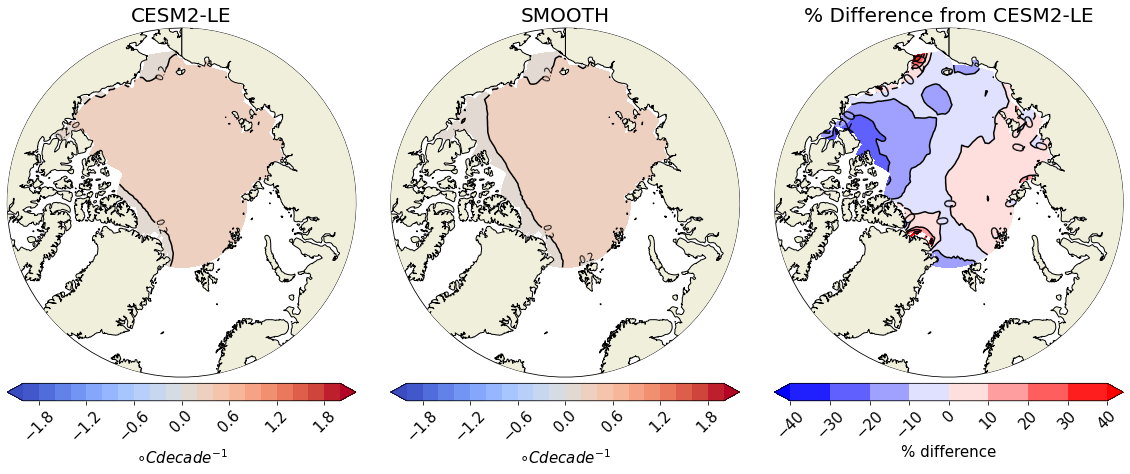

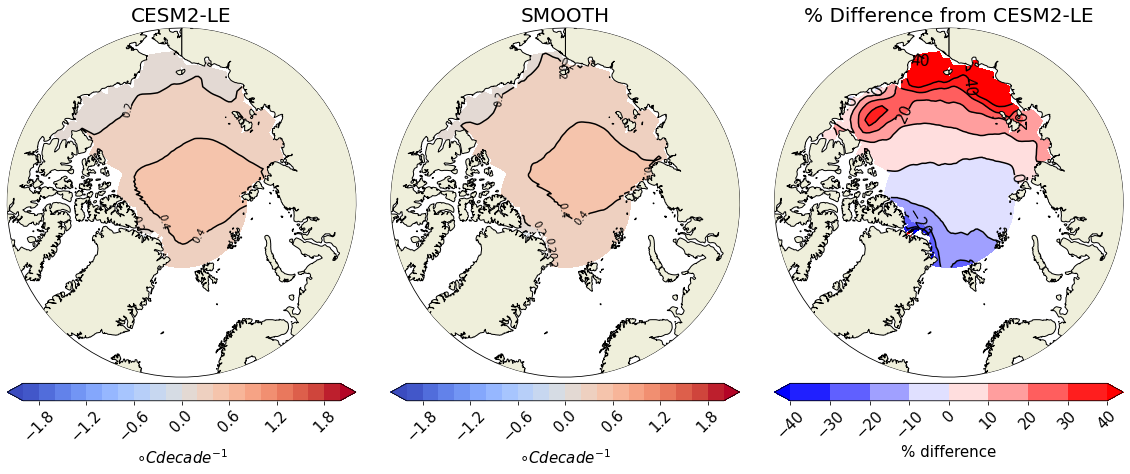

In [31]:
#set some labeling info for plots
units = '$\circ C decade^{-1}$'

# set significance level (0.05 --> 95%; 0.01 --> 99%)
sigval = 0.05

#Plot each season and percent difference
levels_in = np.arange(-2,2.2,0.2)
cmap_in = plt.cm.get_cmap('coolwarm')
levels_diff = np.arange(-40,50,10)
cmap_diff = plt.cm.get_cmap('bwr')

for ss in season_names:
    print('Calculating regressions for '+ss)
    out_tag = 'tgrad_925hpa'
    label = 'temperature gradient (T925 -Tsfc)'
        
    # grab data we want to regress
    tseries = xarr_le[ind_st:ind_ed]
    spatial_le = seas_le_925.sel(season=ss)
    spatial_le = spatial_le[ind_st:ind_ed,:,:]
    spatial_rufmod = seas_rufmod_925.sel(season=ss)
    spatial_rufmod = spatial_rufmod[ind_st:ind_ed,:,:]
        
    # Calculate CESM2-LE regressions (and convert to by decade)
    regcoeff_le=10*regcoeff_array(tseries,spatial_le,'time')
    rvalues_le=rvalue_array(tseries,spatial_le,'time')
    pvalues_le=pvalue_array(tseries,spatial_le,'time')
    regcoeff_le_masked = regcoeff_le.where(pvalues_le < sigval)

    # Calculate rufmod regressions
    regcoeff_rufmod=10*regcoeff_array(tseries,spatial_rufmod,'time')
    rvalues_rufmod=rvalue_array(tseries,spatial_rufmod,'time')
    pvalues_rufmod=pvalue_array(tseries,spatial_rufmod,'time')
    regcoeff_rufmod_masked = regcoeff_rufmod.where(pvalues_rufmod < sigval)
    
    # mask just Arctic Ocean - again
    regcoeff_le = regcoeff_le.where(my_mask==1)
    regcoeff_le_masked = regcoeff_le_masked.where(my_mask==1)
    regcoeff_rufmod = regcoeff_rufmod.where(my_mask==1)
    regcoeff_rufmod_masked = regcoeff_rufmod_masked.where(my_mask==1)

    # calculate difference - need to also set coordinates to be equal
    #regcoeff_rufmod_masked['lat'] = regcoeff_le_masked.lat.values
    #regcoeff_rufmod_masked['lon'] = regcoeff_le_masked.lon.values
    diff = 100*((regcoeff_rufmod - regcoeff_le)/regcoeff_le)
    diff = 100*((regcoeff_rufmod_masked - regcoeff_le_masked)/regcoeff_le_masked)
        
    # add cyclic point
    regcoeff_le = gvutil.xr_add_cyclic_longitudes(regcoeff_le,"lon")
    regcoeff_le_masked = gvutil.xr_add_cyclic_longitudes(regcoeff_le_masked,"lon")
    regcoeff_rufmod = gvutil.xr_add_cyclic_longitudes(regcoeff_rufmod,"lon")    
    regcoeff_rufmod_masked = gvutil.xr_add_cyclic_longitudes(regcoeff_rufmod_masked,"lon")
    pvalues_le = gvutil.xr_add_cyclic_longitudes(pvalues_le,"lon")
    pvalues_rufmod = gvutil.xr_add_cyclic_longitudes(pvalues_rufmod,"lon") 
    diff = gvutil.xr_add_cyclic_longitudes(diff,"lon")

    # create figure
    fig = plt.figure(figsize=(20,20))
    fout = 'cesm2_le_and_rufmod_'+out_tag+'_trends_2020_2100_'+ss
    title = ss+' '+label+' trend over sea ice - 2020-2100'
     
    # Make subplots - note it's nrow x ncol x index (starting upper left)
    # First subplot: CESM2-LE
    ax = fig.add_subplot(1,3,1, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(regcoeff_le.lon,regcoeff_le.lat,
                     regcoeff_le,
                     cmap=cmap_in,levels=levels_in,extend='both',
                     transform=ccrs.PlateCarree())
    # add contour lines and labels
    this2=ax.contour(regcoeff_le.lon,regcoeff_le.lat,
                     regcoeff_le,
                     colors='black',linestyles='solid',levels=levels_in,
                     transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels, inline=True, fontsize=10, colors='black')
    # add significance overlay
    sig = ax.pcolor(pvalues_le.lon,pvalues_le.lat,
                       pvalues_le.where(pvalues_le > sigval),
                       alpha=0, hatch='xx',
                       transform=ccrs.PlateCarree())    
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel(units, fontsize=15)
    plt.title('CESM2-LE',fontsize=20)
    
    # Second subplot: Rufmod aka SMOOTH
    ax = fig.add_subplot(1,3,2, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(regcoeff_rufmod.lon,regcoeff_rufmod.lat,
                       regcoeff_rufmod,
                       cmap=cmap_in,levels=levels_in,extend='both',
                       transform=ccrs.PlateCarree())
    # add contour lines and labels
    this2=ax.contour(regcoeff_rufmod.lon,regcoeff_rufmod.lat,
                       regcoeff_rufmod,
                       colors='black',linestyles='solid',levels=levels_in,
                       transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels, inline=True, fontsize=10, colors='black')
    # add significance overlay
    sig = ax.pcolor(pvalues_rufmod.lon,pvalues_rufmod.lat,
                       pvalues_rufmod.where(pvalues_rufmod > sigval),
                       alpha=0, hatch='xx',
                       transform=ccrs.PlateCarree())    
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel(units, fontsize=15)
    plt.title('SMOOTH',fontsize=20)
    
    # Third subplot: %difference
    ax = fig.add_subplot(1,3,3, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(diff.lon,diff.lat,
                       diff,
                       cmap=cmap_diff,levels=levels_diff,extend='both',
                       transform=ccrs.PlateCarree())
    # add contour lines and labels
    this2=ax.contour(diff.lon,diff.lat,
                       diff,
                       colors='black',linestyles='solid',levels=levels_diff,
                       transform=ccrs.PlateCarree())    
    plt.gca().clabel(this2,this2.levels[::2], inline=True, fontsize=15, colors='black') 
    
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel('% difference', fontsize=15)
    plt.title('% Difference from CESM2-LE',fontsize=20)
    
    # Finalize figure and save
    #fig.suptitle(title,fontsize=15, y=0.75)  
    fig.subplots_adjust(bottom=0.45,wspace=0.1)
    #fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)  
        

Calculating regressions for OND


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating regressions for JFM


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating regressions for AMJ


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating regressions for JAS


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


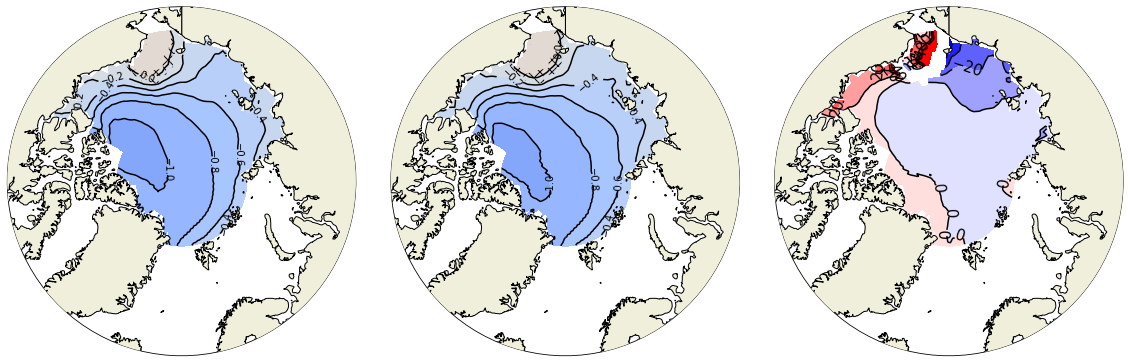

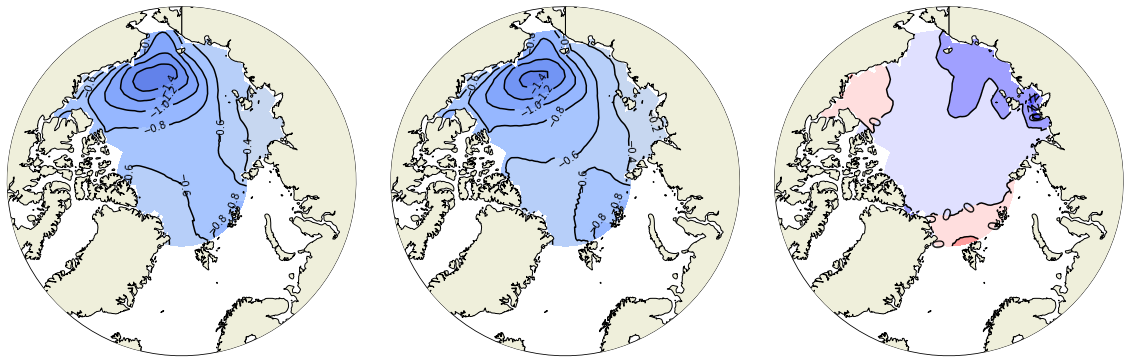

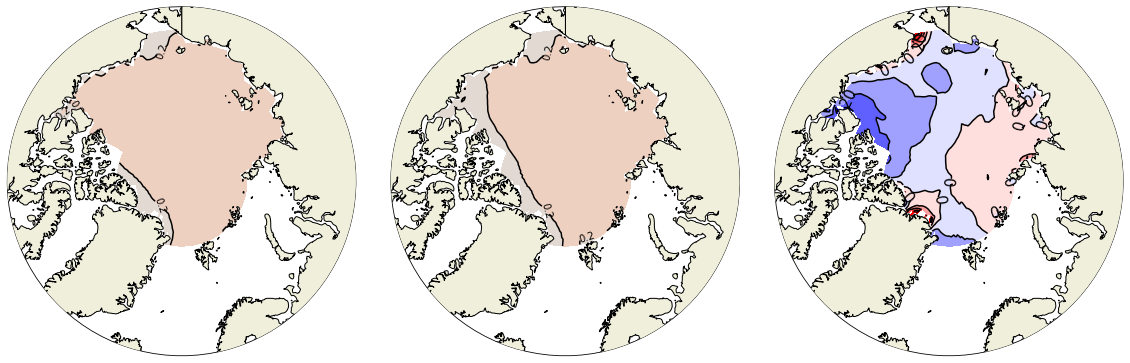

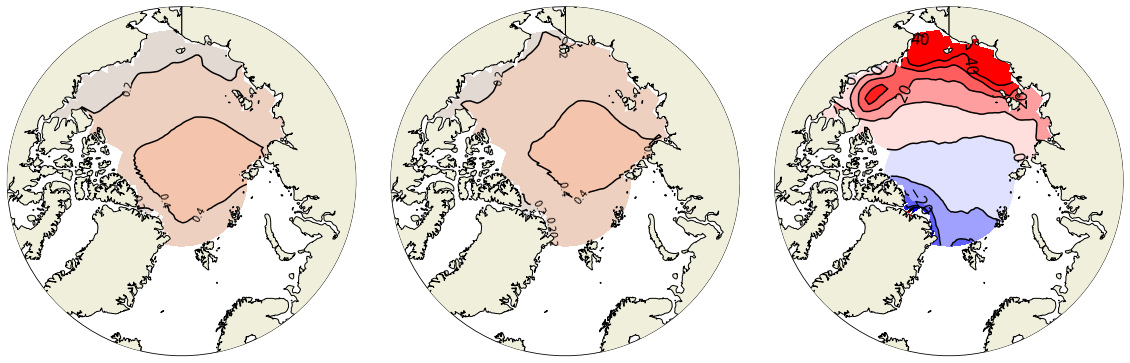

In [32]:
#set some labeling info for plots
units = '$\circ C decade^{-1}$'

# set significance level (0.05 --> 95%; 0.01 --> 99%)
sigval = 0.05

#Plot each season and percent difference
levels_in = np.arange(-2,2.2,0.2)
cmap_in = plt.cm.get_cmap('coolwarm')
levels_diff = np.arange(-40,50,10)
cmap_diff = plt.cm.get_cmap('bwr')

for ss in season_names:
    print('Calculating regressions for '+ss)
    out_tag = 'tgrad_925hpa'
    label = 'temperature gradient (T925 -Tsfc)'
        
    # grab data we want to regress
    tseries = xarr_le[ind_st:ind_ed]
    spatial_le = seas_le_925.sel(season=ss)
    spatial_le = spatial_le[ind_st:ind_ed,:,:]
    spatial_rufmod = seas_rufmod_925.sel(season=ss)
    spatial_rufmod = spatial_rufmod[ind_st:ind_ed,:,:]
        
    # Calculate CESM2-LE regressions (and convert to by decade)
    regcoeff_le=10*regcoeff_array(tseries,spatial_le,'time')
    rvalues_le=rvalue_array(tseries,spatial_le,'time')
    pvalues_le=pvalue_array(tseries,spatial_le,'time')
    regcoeff_le_masked = regcoeff_le.where(pvalues_le < sigval)

    # Calculate rufmod regressions
    regcoeff_rufmod=10*regcoeff_array(tseries,spatial_rufmod,'time')
    rvalues_rufmod=rvalue_array(tseries,spatial_rufmod,'time')
    pvalues_rufmod=pvalue_array(tseries,spatial_rufmod,'time')
    regcoeff_rufmod_masked = regcoeff_rufmod.where(pvalues_rufmod < sigval)
    
    # mask just Arctic Ocean - again
    regcoeff_le = regcoeff_le.where(my_mask==1)
    regcoeff_le_masked = regcoeff_le_masked.where(my_mask==1)
    regcoeff_rufmod = regcoeff_rufmod.where(my_mask==1)
    regcoeff_rufmod_masked = regcoeff_rufmod_masked.where(my_mask==1)

    # calculate difference - need to also set coordinates to be equal
    #regcoeff_rufmod_masked['lat'] = regcoeff_le_masked.lat.values
    #regcoeff_rufmod_masked['lon'] = regcoeff_le_masked.lon.values
    diff = 100*((regcoeff_rufmod - regcoeff_le)/regcoeff_le)
    diff = 100*((regcoeff_rufmod_masked - regcoeff_le_masked)/regcoeff_le_masked)
        
    # add cyclic point
    regcoeff_le = gvutil.xr_add_cyclic_longitudes(regcoeff_le,"lon")
    regcoeff_le_masked = gvutil.xr_add_cyclic_longitudes(regcoeff_le_masked,"lon")
    regcoeff_rufmod = gvutil.xr_add_cyclic_longitudes(regcoeff_rufmod,"lon")    
    regcoeff_rufmod_masked = gvutil.xr_add_cyclic_longitudes(regcoeff_rufmod_masked,"lon")
    pvalues_le = gvutil.xr_add_cyclic_longitudes(pvalues_le,"lon")
    pvalues_rufmod = gvutil.xr_add_cyclic_longitudes(pvalues_rufmod,"lon") 
    diff = gvutil.xr_add_cyclic_longitudes(diff,"lon")

    # create figure
    fig = plt.figure(figsize=(20,20))
    fout = 'fig_10_'+out_tag+'_trends_2020_2100_'+ss
    title = ss+' '+label+' trend over sea ice - 2020-2100'
     
    # Make subplots - note it's nrow x ncol x index (starting upper left)
    # First subplot: CESM2-LE
    ax = fig.add_subplot(1,3,1, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(regcoeff_le.lon,regcoeff_le.lat,
                     regcoeff_le,
                     cmap=cmap_in,levels=levels_in,extend='both',
                     transform=ccrs.PlateCarree())
    # add contour lines and labels
    this2=ax.contour(regcoeff_le.lon,regcoeff_le.lat,
                     regcoeff_le,
                     colors='black',linestyles='solid',levels=levels_in,
                     transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels, inline=True, fontsize=10, colors='black')
    # add significance overlay
    sig = ax.pcolor(pvalues_le.lon,pvalues_le.lat,
                       pvalues_le.where(pvalues_le > sigval),
                       alpha=0, hatch='xx',
                       transform=ccrs.PlateCarree())    
    
    # Second subplot: Rufmod aka SMOOTH
    ax = fig.add_subplot(1,3,2, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(regcoeff_rufmod.lon,regcoeff_rufmod.lat,
                       regcoeff_rufmod,
                       cmap=cmap_in,levels=levels_in,extend='both',
                       transform=ccrs.PlateCarree())
    # add contour lines and labels
    this2=ax.contour(regcoeff_rufmod.lon,regcoeff_rufmod.lat,
                       regcoeff_rufmod,
                       colors='black',linestyles='solid',levels=levels_in,
                       transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels, inline=True, fontsize=10, colors='black')
    # add significance overlay
    sig = ax.pcolor(pvalues_rufmod.lon,pvalues_rufmod.lat,
                       pvalues_rufmod.where(pvalues_rufmod > sigval),
                       alpha=0, hatch='xx',
                       transform=ccrs.PlateCarree())    
    
    # Third subplot: %difference
    ax = fig.add_subplot(1,3,3, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(diff.lon,diff.lat,
                       diff,
                       cmap=cmap_diff,levels=levels_diff,extend='both',
                       transform=ccrs.PlateCarree())
    # add contour lines and labels
    this2=ax.contour(diff.lon,diff.lat,
                       diff,
                       colors='black',linestyles='solid',levels=levels_diff,
                       transform=ccrs.PlateCarree())    
    plt.gca().clabel(this2,this2.levels[::2], inline=True, fontsize=15, colors='black') 
    
    # Finalize figure and save
    #fig.suptitle(title,fontsize=15, y=0.75)  
    fig.subplots_adjust(bottom=0.45,wspace=0.1)
    fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)  
        

Calculating regressions for OND


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


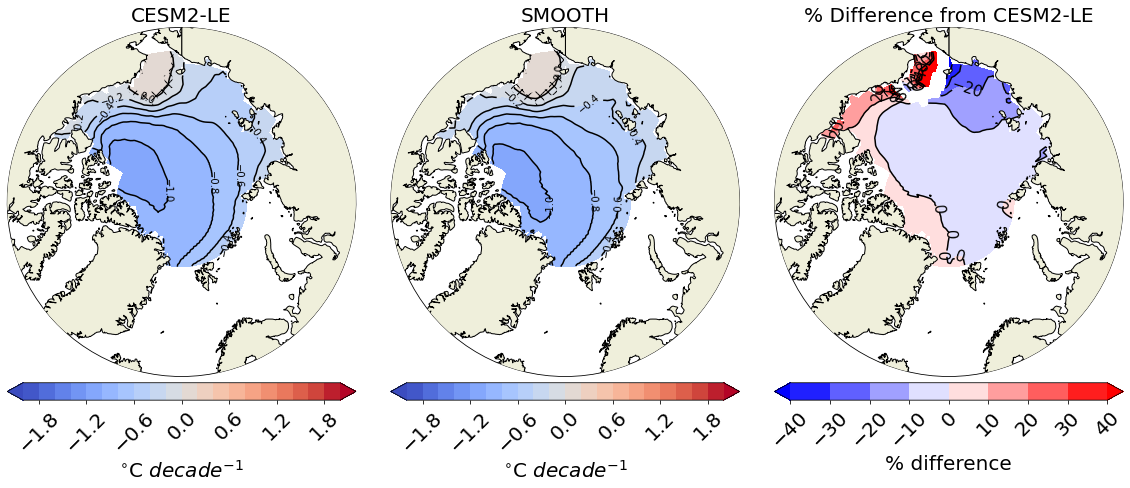

In [33]:
#set some labeling info for plots
units = '$^{\circ}$C $decade^{-1}$'

# set significance level (0.05 --> 95%; 0.01 --> 99%)
sigval = 0.05

#Plot each season and percent difference
levels_in = np.arange(-2,2.2,0.2)
cmap_in = plt.cm.get_cmap('coolwarm')
levels_diff = np.arange(-40,50,10)
cmap_diff = plt.cm.get_cmap('bwr')

for ss in season_names[0:1]:
    print('Calculating regressions for '+ss)
    out_tag = 'tgrad_925hpa'
    label = 'temperature gradient (T925 -Tsfc)'
        
    # grab data we want to regress
    tseries = xarr_le[ind_st:ind_ed]
    spatial_le = seas_le_925.sel(season=ss)
    spatial_le = spatial_le[ind_st:ind_ed,:,:]
    spatial_rufmod = seas_rufmod_925.sel(season=ss)
    spatial_rufmod = spatial_rufmod[ind_st:ind_ed,:,:]
        
    # Calculate CESM2-LE regressions (and convert to by decade)
    regcoeff_le=10*regcoeff_array(tseries,spatial_le,'time')
    rvalues_le=rvalue_array(tseries,spatial_le,'time')
    pvalues_le=pvalue_array(tseries,spatial_le,'time')
    regcoeff_le_masked = regcoeff_le.where(pvalues_le < sigval)

    # Calculate rufmod regressions
    regcoeff_rufmod=10*regcoeff_array(tseries,spatial_rufmod,'time')
    rvalues_rufmod=rvalue_array(tseries,spatial_rufmod,'time')
    pvalues_rufmod=pvalue_array(tseries,spatial_rufmod,'time')
    regcoeff_rufmod_masked = regcoeff_rufmod.where(pvalues_rufmod < sigval)
    
    # mask just Arctic Ocean - again
    regcoeff_le = regcoeff_le.where(my_mask==1)
    regcoeff_le_masked = regcoeff_le_masked.where(my_mask==1)
    regcoeff_rufmod = regcoeff_rufmod.where(my_mask==1)
    regcoeff_rufmod_masked = regcoeff_rufmod_masked.where(my_mask==1)

    # calculate difference - need to also set coordinates to be equal
    #regcoeff_rufmod_masked['lat'] = regcoeff_le_masked.lat.values
    #regcoeff_rufmod_masked['lon'] = regcoeff_le_masked.lon.values
    diff = 100*((regcoeff_rufmod - regcoeff_le)/regcoeff_le)
    diff = 100*((regcoeff_rufmod_masked - regcoeff_le_masked)/regcoeff_le_masked)
        
    # add cyclic point
    regcoeff_le = gvutil.xr_add_cyclic_longitudes(regcoeff_le,"lon")
    regcoeff_le_masked = gvutil.xr_add_cyclic_longitudes(regcoeff_le_masked,"lon")
    regcoeff_rufmod = gvutil.xr_add_cyclic_longitudes(regcoeff_rufmod,"lon")    
    regcoeff_rufmod_masked = gvutil.xr_add_cyclic_longitudes(regcoeff_rufmod_masked,"lon")
    pvalues_le = gvutil.xr_add_cyclic_longitudes(pvalues_le,"lon")
    pvalues_rufmod = gvutil.xr_add_cyclic_longitudes(pvalues_rufmod,"lon") 
    diff = gvutil.xr_add_cyclic_longitudes(diff,"lon")

    # create figure
    fig = plt.figure(figsize=(20,20))
    fout = 'fig_10_contours'
    title = ss+' '+label+' trend over sea ice - 2020-2100'
     
    # Make subplots - note it's nrow x ncol x index (starting upper left)
    # First subplot: CESM2-LE
    ax = fig.add_subplot(1,3,1, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(regcoeff_le.lon,regcoeff_le.lat,
                     regcoeff_le,
                     cmap=cmap_in,levels=levels_in,extend='both',
                     transform=ccrs.PlateCarree())
    # add contour lines and labels
    this2=ax.contour(regcoeff_le.lon,regcoeff_le.lat,
                     regcoeff_le,
                     colors='black',linestyles='solid',levels=levels_in,
                     transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels, inline=True, fontsize=10, colors='black')
    # add significance overlay
    sig = ax.pcolor(pvalues_le.lon,pvalues_le.lat,
                       pvalues_le.where(pvalues_le > sigval),
                       alpha=0, hatch='xx',
                       transform=ccrs.PlateCarree())    
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=20, labelrotation=45)
    cbar.ax.set_xlabel(units, fontsize=20)
    plt.title('CESM2-LE',fontsize=20)
    
    # Second subplot: Rufmod aka SMOOTH
    ax = fig.add_subplot(1,3,2, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(regcoeff_rufmod.lon,regcoeff_rufmod.lat,
                       regcoeff_rufmod,
                       cmap=cmap_in,levels=levels_in,extend='both',
                       transform=ccrs.PlateCarree())
    # add contour lines and labels
    this2=ax.contour(regcoeff_rufmod.lon,regcoeff_rufmod.lat,
                       regcoeff_rufmod,
                       colors='black',linestyles='solid',levels=levels_in,
                       transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels, inline=True, fontsize=10, colors='black')
    # add significance overlay
    sig = ax.pcolor(pvalues_rufmod.lon,pvalues_rufmod.lat,
                       pvalues_rufmod.where(pvalues_rufmod > sigval),
                       alpha=0, hatch='xx',
                       transform=ccrs.PlateCarree())    
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=20, labelrotation=45)
    cbar.ax.set_xlabel(units, fontsize=20)
    plt.title('SMOOTH',fontsize=20)
    
    # Third subplot: %difference
    ax = fig.add_subplot(1,3,3, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(diff.lon,diff.lat,
                       diff,
                       cmap=cmap_diff,levels=levels_diff,extend='both',
                       transform=ccrs.PlateCarree())
    # add contour lines and labels
    this2=ax.contour(diff.lon,diff.lat,
                       diff,
                       colors='black',linestyles='solid',levels=levels_diff,
                       transform=ccrs.PlateCarree())    
    plt.gca().clabel(this2,this2.levels[::2], inline=True, fontsize=15, colors='black') 
    
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=20, labelrotation=45)
    cbar.ax.set_xlabel('% difference', fontsize=20)
    plt.title('% Difference from CESM2-LE',fontsize=20)
    
    # Finalize figure and save
    #fig.suptitle(title,fontsize=15, y=0.75)  
    fig.subplots_adjust(bottom=0.45,wspace=0.1)
    fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)  
        